In [27]:
import kagglegym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from time import time
import bz2
import base64
import pickle as pk
import warnings
import math

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

## Exploratory analysis

In [2]:
# The "environment" is our interface.
env = kagglegym.make()

# We get our initial observation by calling "reset".
o = env.reset()

#excl = [env.ID_COL_NAME, env.SAMPLE_COL_NAME, env.TARGET_COL_NAME, env.TIME_COL_NAME]

excl = ["id", "timestamp", "y"]
col = [c for c in o.train.columns if c not in excl]
train = o.train.loc[:, col]

# Total number of NA values per observation.
train_NA_values = train.isnull().sum(axis=1)

# Sigmoid transformation
#for c in col:
 #   train.loc[:, c] = 1 / (1 + np.exp(-train.loc[:, c]))
    
# Record NA values and then fill them with the median.
d_mean = train.median(axis=0)

for c in col:
    train.loc[:, c + "_nan"] = pd.isnull(train[c])
    d_mean[c + "_nan"] = 0
    
train = train.fillna(d_mean)

train.loc[:, "is_null"] = train_NA_values

In [ ]:
# Add by ID and timestamp: std & mean + nb assets

In [102]:
#######
# Train pickle model
#######
full_train = pd.read_hdf("train.h5")

### Evolution of target value and number of assets by timestamp

In [4]:
# Plot the correlation of the variables with the target value.
correlation = []
columns = []

for c in col:
    columns.append(c)
    correlation.append(np.corrcoef(train[c], o.train["y"])[0, 1])

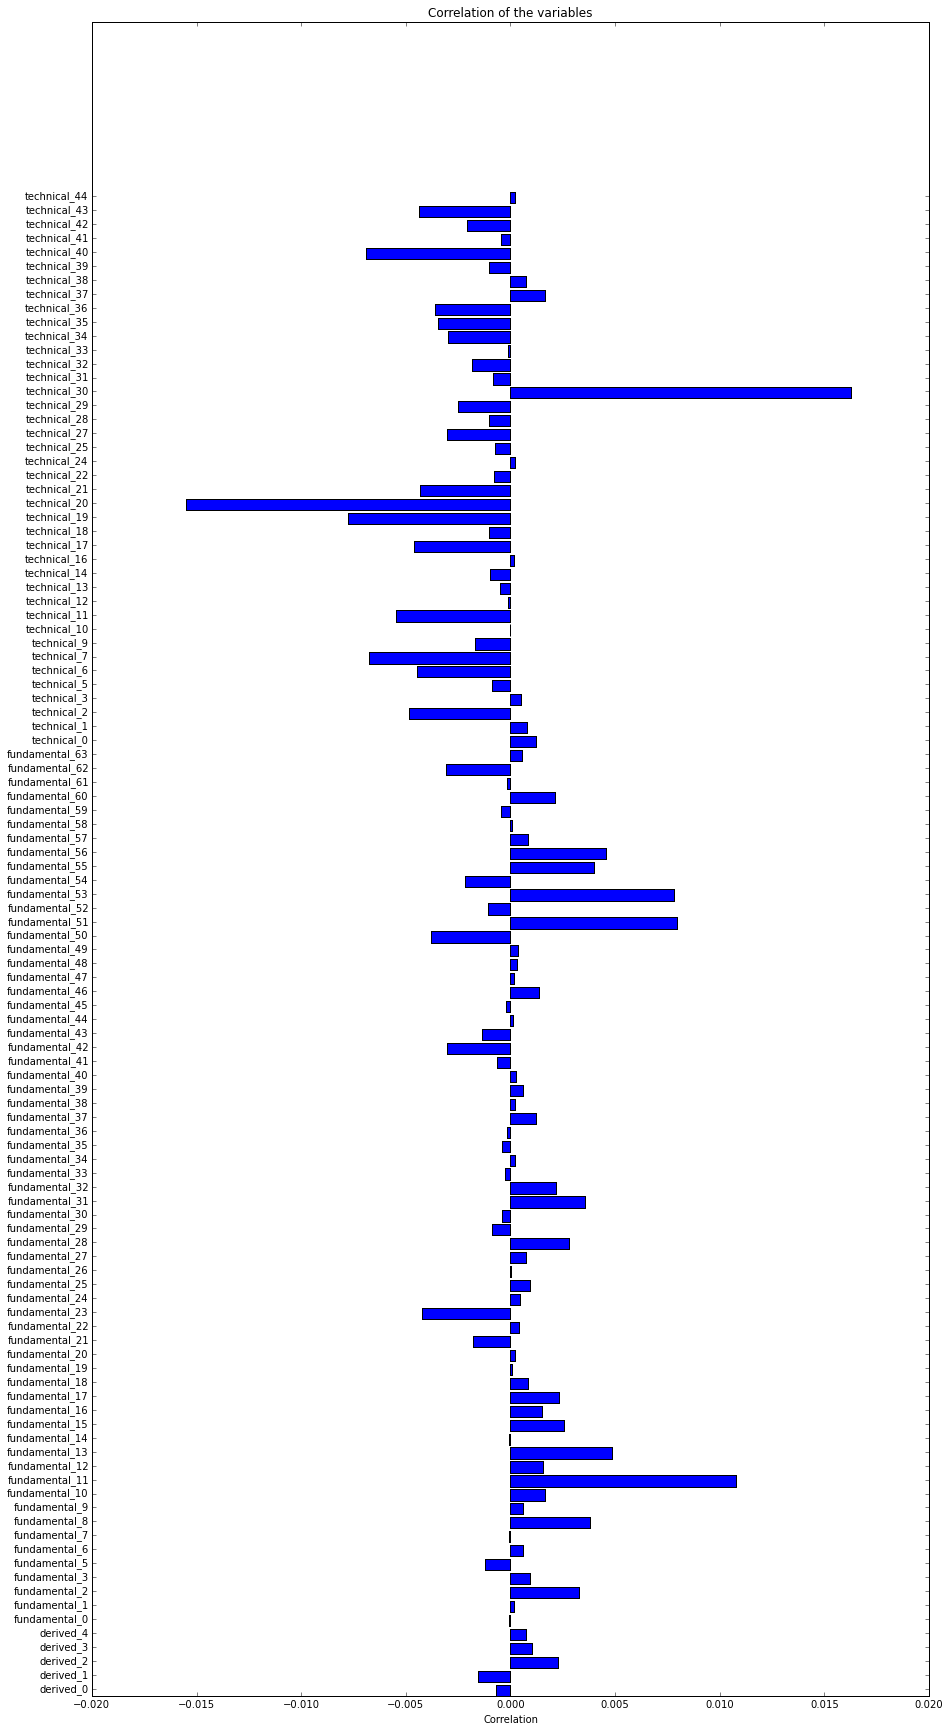

In [5]:
fig, ax = plt.subplots(figsize=(15, 30))
grid = np.arange(len(correlation))
ax.barh(grid, correlation)
ax.set_yticks(grid + 0.5)
ax.set_title("Correlation of the variables")
ax.set_xlabel("Correlation")
ax.set_yticklabels(columns, rotation="horizontal")
plt.show()

The most correlated variables are: technical_20, technical_30, fundamental_11.

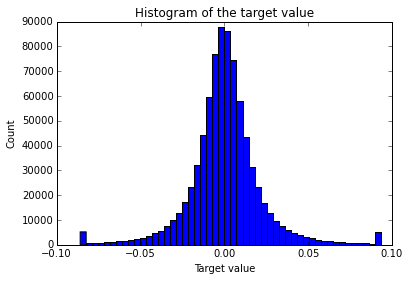

In [7]:
# Plot histogram of the target value.
plt.hist(o.train["y"], bins=50)
plt.title("Histogram of the target value")
plt.xlabel("Target value")
plt.ylabel("Count")
plt.show()

Notice the two spikes at the extremes of the histogram: the target might have been clipped and should be dealt with accordingly in our following linear model.

### Time series

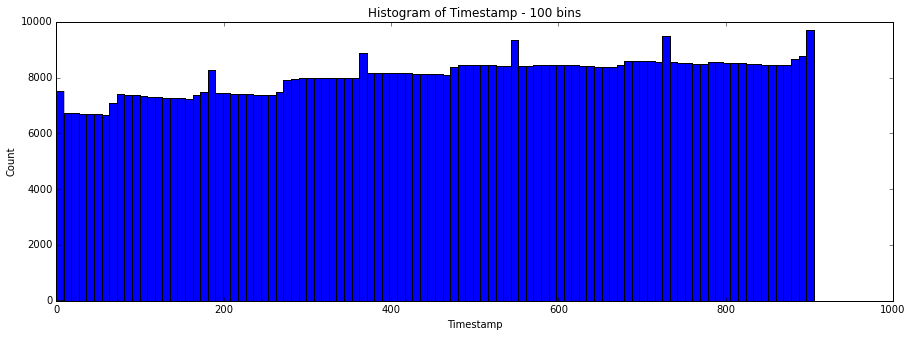

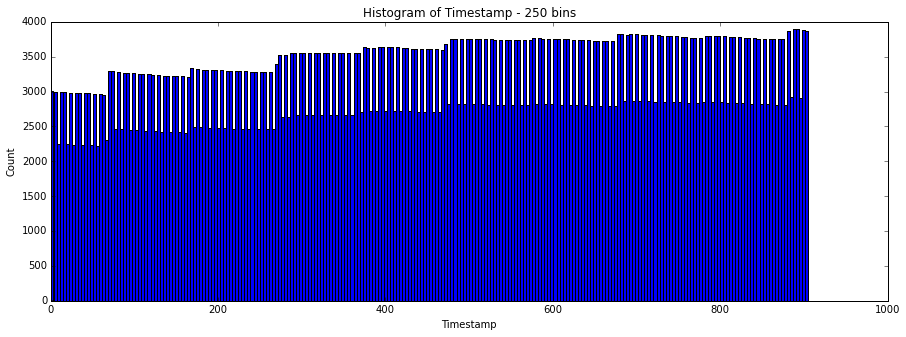

In [19]:
# Timestamp repartition
timestamp = o.train.timestamp.values
for bins in [100, 250]:
    plt.figure(figsize=(15, 5))
    plt.hist(timestamp, bins=bins)
    plt.xlabel("Timestamp")
    plt.ylabel("Count")
    plt.title("Histogram of Timestamp - {} bins".format(bins))

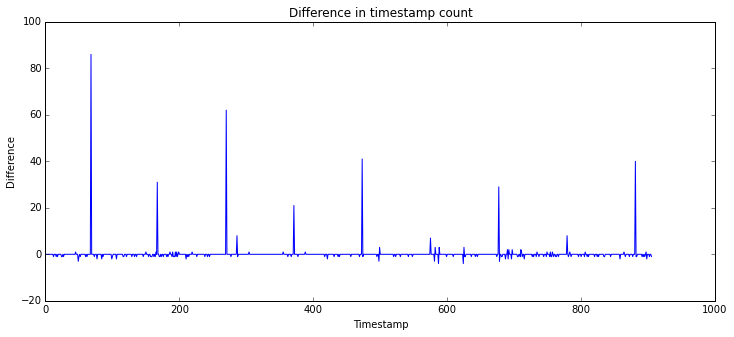

0      NaN
1     99.0
2    103.0
3    101.0
4    102.0
5    204.0
6    204.0
Name: timestamp, dtype: float64

In [3]:
time_diff = o.train.groupby(["timestamp"])["timestamp"].count().diff()

plt.figure(figsize=(12, 5))
plt.plot(time_diff)
plt.title("Difference in timestamp count")
plt.xlabel("Timestamp")
plt.ylabel("Difference")
plt.show()

pd.Series(time_diff[time_diff > 10].index).diff()

In [4]:
# Peaks can be approximated by 100*x + 70
time_diff[time_diff > 5]

timestamp
68     86.0
167    31.0
270    62.0
286     8.0
371    21.0
473    41.0
575     7.0
677    29.0
779     8.0
881    40.0
Name: timestamp, dtype: float64

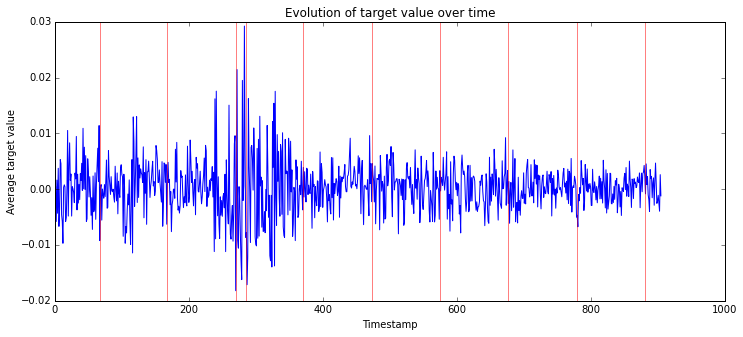

In [44]:
# Target value distribution over timestamp
y_distribution = o.train.groupby(["timestamp"])["y"].mean()
plt.figure(figsize=(12, 5))
plt.plot(y_distribution)
plt.xlabel("Timestamp")
plt.ylabel("Average target value")
plt.title("Evolution of target value over time")
for i in time_diff[time_diff > 5].index:
    plt.axvline(x=i, linewidth=0.5, color="red")
plt.show()

In [5]:
peak_dict = dict(((time_diff > 5).map(lambda x: 1 if x else 0)
                  + (time_diff > 10).map(lambda x: 1 if x else 0)))

## Models

In [103]:
low_y_cut = -0.075
high_y_cut = 0.075
y_is_above_cut = (o.train.y > high_y_cut)
y_is_below_cut = (o.train.y < low_y_cut)
y_is_within_cut = (~y_is_above_cut & ~y_is_below_cut)
model_1 = LinearRegression(n_jobs=-1)
model_1.fit(np.array(train.loc[y_is_within_cut, "technical_20"].values).reshape(-1, 1), 
            o.train.loc[y_is_within_cut, "y"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [104]:
# Fit an ExtraTreesRegressor
t0 = time()

extra_trees = ExtraTreesRegressor(n_estimators=200, max_depth=6, n_jobs=-1, 
                                  random_state=17, verbose=0)
model_2 = extra_trees.fit(train, o.train["y"])

train = []

print("Running time: {0}s.".format(time() - t0))

Running time: 1722.89324713s.


In [94]:
# Using pickle to save model.
#saved_model_2 = base64.standard_b64encode(bz2.compress(pk.dumps(model_2)))
#print(saved_model_2)

In [10]:
model_2_str = """
"""

# base model with sigmoid transformation

In [11]:
# Load saved model.
# Add "encoding="latin1" to the pk.loads method to decode in Python 3
warnings.simplefilter("ignore", UserWarning)
model_2 = pk.loads(bz2.decompress(base64.standard_b64decode(model_2_str)))
model_2

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=4,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=100, n_jobs=-1, oob_score=False, random_state=17,
          verbose=0, warm_start=False)

## Prevent overfitting

In [82]:
# A custom function to compute the R score
def get_reward(y_true, y_fit):
    R2 = 1 - np.sum((y_true - y_fit)**2) / np.sum((y_true - np.mean(y_true))**2)
    R = np.sign(R2) * math.sqrt(abs(R2))
    return(R)

## Prediction

In [105]:
#https://www.kaggle.com/ymcdull/two-sigma-financial-modeling/ridge-lb-0-0100659
ymean_dict = dict(o.train.groupby(["id"])["y"].median())

t0 = time()

y_real = []
y_predict = []
cum_reward = []
timestamp_list = []

while True:
    test = o.features.loc[:, col]

    # Total number of NA values per observation.
    test_NA_values = test.isnull().sum(axis=1)
    
    # Sigmoid transformation
    #for c in col:
        #test.loc[:, c] = 1 / (1 + np.exp(-test.loc[:, c]))
    
    # Fill NA values.
    for c in col:
        test.loc[:, c + "_nan"] = pd.isnull(test[c])

    test = test.fillna(d_mean)
    
    test.loc[:, "is_null"] = test_NA_values

    pred = o.target
    test_technical_20 = np.array(test["technical_20"].values).reshape(-1, 1)
    
    # Ponderation of the two models.
    pred["y"] = ((model_1.predict(test_technical_20).clip(low_y_cut, high_y_cut) * 0.35)
                 + (model_2.predict(test).clip(low_y_cut, high_y_cut) * 0.65))
    # Add the median of the target value by ID.
    pred["y"] = pred.apply(lambda x: 0.95 * x["y"] + 0.05 * ymean_dict[x["id"]] 
                           if x["id"] in ymean_dict 
                           else x["y"], axis=1)
    
    # The target values have 6 decimals in the training set.
    pred["y"] = [float(format(x, ".6f")) for x in pred["y"]]
    
    current_y_real = list(full_train.loc[
            full_train["timestamp"] == o.features.timestamp[0], "y"].values)
    current_y_predict = list(pred["y"].values)
    
    y_real.extend(current_y_real)
    y_predict.extend(current_y_predict)
    
    current_reward = get_reward(np.array(y_real), np.array(y_predict))
    cum_reward.append(current_reward)
    
    timestamp_list.append(o.features.timestamp[0])
    
    o, reward, done, info = env.step(pred)
    if done:
        print("Finished", info["public_score"])
        break
    if o.features.timestamp[0] % 100 == 0:
        print(current_reward)

print("Running time: {0}s.".format(time() - t0))

0.0120561385983
0.00853670258148
0.0164804278316
0.014440084008
-0.0110857910212
0.00887544708997
0.0274960238222
0.0262467319802
0.0239089511734
('Finished', 0.023592082210886534)
Running time: 523.676628828s.


## Cumulative R value

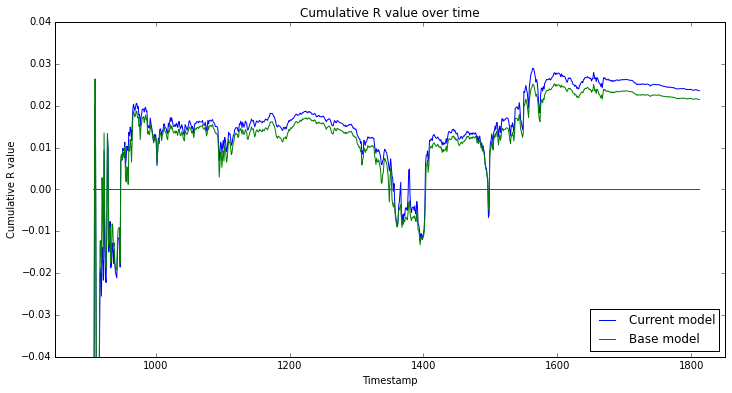

In [106]:
base_cum_R = pd.read_csv("base_cum_R.csv", encoding="utf-8")

plt.figure(figsize=(12,6))
plt.plot(base_cum_R["Timestamp"], cum_reward, color="blue", label="Current model")
plt.plot(base_cum_R["Timestamp"], base_cum_R["Cumulative_R"], color="green", label="Base model")
plt.plot(base_cum_R["Timestamp"], [0]*len(timestamp_list), color="red")
plt.title("Cumulative R value over time")
plt.xlabel("Timestamp")
plt.ylabel("Cumulative R value")
plt.xlim(850, 1850)
plt.ylim(-0.04, 0.04)
plt.legend(loc="lower right")
plt.show()

##Cross-validation

In [22]:
n_estimators_grid = [200, 300]
max_depth_grid = [5, 6]

score = []

t0 = time()

for n_estimators in n_estimators_grid:
    for max_depth in max_depth_grid:
        
        print("Parameters: \n     n_estimators:{0} \n     max_depth: {1}"\
              .format(n_estimators, max_depth))
        
        # The "environment" is our interface.
        env = kagglegym.make()

        # We get our initial observation by calling "reset".
        o = env.reset()

        excl = ["id", "timestamp", "y"]
        col = [c for c in o.train.columns if c not in excl]
        train = o.train.loc[:, col]

        # Total number of NA values per observation.
        train.loc[:, "is_null"] = train.isnull().sum(axis=1)

        # Record NA values and then fill them with the median.
        d_mean = train.median(axis=0)

        for c in col:
            train.loc[:, c + "_nan"] = pd.isnull(train[c])
            d_mean[c + "_nan"] = 0

        train = train.fillna(d_mean)
        
        # Model 1
        low_y_cut = -0.075
        high_y_cut = 0.075
        y_is_above_cut = (o.train.y > high_y_cut)
        y_is_below_cut = (o.train.y < low_y_cut)
        y_is_within_cut = (~y_is_above_cut & ~y_is_below_cut)
        model_1 = LinearRegression(n_jobs=-1)
        model_1.fit(np.array(train.loc[y_is_within_cut, "technical_20"].values).reshape(-1, 1), 
                    o.train.loc[y_is_within_cut, "y"])
        
        # Model 2
        extra_trees = ExtraTreesRegressor(n_estimators=n_estimators, max_depth=max_depth, 
                                          n_jobs=-1, random_state=17, verbose=0)
        model_2 = extra_trees.fit(train, o.train["y"])

        ymean_dict = dict(o.train.groupby(["id"])["y"].median())

        while True:
            test = o.features.loc[:, col]
            # Total number of NA values per observation.
            test.loc[:, "is_null"] = test.isnull().sum(axis=1)

            # Fill NA values.
            for c in col:
                test.loc[:, c + "_nan"] = pd.isnull(test[c])

            test = test.fillna(d_mean)

            pred = o.target
            test_technical_20 = np.array(test["technical_20"].values).reshape(-1, 1)

            # Ponderation of the two models.
            pred["y"] = ((model_1.predict(test_technical_20).clip(low_y_cut, high_y_cut) * 0.35)
                         + (model_2.predict(test).clip(low_y_cut, high_y_cut) * 0.65))
            # Add the median of the target value by ID.
            pred["y"] = pred.apply(lambda x: 0.95 * x["y"] + 0.05 * ymean_dict[x["id"]] if x["id"] in ymean_dict else x["y"], axis=1)

            # The target values have 6 decimals in the training set.
            pred["y"] = [float(format(x, ".6f")) for x in pred["y"]]

            o, reward, done, info = env.step(pred)
            if done:
                print("Finished", info["public_score"])
                break
            if o.features.timestamp[0] % 100 == 0:
                print(reward)
        
        score.append(info["public_score"])

        print("Running time: {0}s.".format(time() - t0))

Parameters: 
     n_estimators:200 
     max_depth: 5
-0.317612904033
-0.182022570997
-0.169765407348
0.0155721899717
-0.120887529213
-0.161751403784
-0.207983802147
-0.304530203505
-0.0193565919651
('Finished', 0.022544354775984359)
Running time: 1942.98224711s.
Parameters: 
     n_estimators:200 
     max_depth: 6
-0.317964370131
-0.181636354313
-0.170090172396
0.0210891114915
-0.122100133863
-0.15869220995
-0.208973403429
-0.304452852273
-0.0227012427798
('Finished', 0.023818689235850024)
Running time: 4134.09156013s.
Parameters: 
     n_estimators:300 
     max_depth: 5
-0.317710106052
-0.18212292887
-0.169783469952
0.0200483728335
-0.121449198546
-0.16200032081
-0.208525665085
-0.304498983443
-0.0229799518439
('Finished', 0.022265339569625051)
Running time: 6898.75451612s.
Parameters: 
     n_estimators:300 
     max_depth: 6
-0.318000512358
-0.18192592894
-0.170338108637
0.0224381742101
-0.123044219716
-0.158405005328
-0.210106180808
-0.304121947237
-0.0268123027067
('Finished', 

In [ ]:
#0.0148877463784 for model_1 only (8 mins)
#0.021473779155142633  for model_1 and model_2 (7 mins)

# First cross-validation
#Parameters: 
     #n_estimators:200 
     #max_depth: 5
#
#('Finished', 0.022544354775984359)

#Running time: 1942.98224711s.
#Parameters: 
     #n_estimators:200 
     #max_depth: 6
#('Finished', 0.023818689235850024)
#Running time: 4134.09156013s.
#Parameters: 
     #n_estimators:300 
     #max_depth: 5
#('Finished', 0.022265339569625051)

#Running time: 6898.75451612s.
#Parameters: 
     #n_estimators:300 
     #max_depth: 6
#('Finished', 0.023778939527378237)
#Running time: 10013.6646042s.

## Approximating LB score

In [38]:
full_train = pd.read_hdf("train.h5")
o_train, o_test = train_test_split(full_train, test_size = 0.5, random_state=0)

In [39]:
excl = ["id", "timestamp", "y"]
#excl = [env.ID_COL_NAME, env.SAMPLE_COL_NAME, env.TARGET_COL_NAME, env.TIME_COL_NAME]
col = [c for c in o_train.columns if c not in excl]
train = o_train.loc[:, col]

# Total number of NA values per observation.
train_NA_values = train.isnull().sum(axis=1)

# Record NA values and then fill them with the median.
d_mean = train.median(axis=0)

for c in col:
    train.loc[:, c + "_nan"] = pd.isnull(train[c])
    d_mean[c + "_nan"] = 0
    
train = train.fillna(d_mean)

train.loc[:, "is_null"] = train_NA_values

model_2_mask = pd.read_csv("model_2_mask.csv", encoding="utf-8")
train = train.loc[:, train.columns[model_2_mask["mask"]]]

# By timestamp: std of target value thanks to the variable "technical_30" and count of assets.
#dict_y_std_timestamp = dict(np.sqrt(o_train.groupby("timestamp")["technical_30"].var()))
#train.loc[:, "y_std_timestamp"] = o_train["timestamp"].map(dict_y_std_timestamp)

#dict_assets_count = dict(o_train.groupby("timestamp")["id"].count())
#train.loc[:, "assets_count"] = o_train["timestamp"].map(dict_assets_count)

In [40]:
# Train model
low_y_cut = -0.075
high_y_cut = 0.075
y_is_above_cut = (o_train.y > high_y_cut)
y_is_below_cut = (o_train.y < low_y_cut)
y_is_within_cut = (~y_is_above_cut & ~y_is_below_cut)
model_1 = LinearRegression(n_jobs=-1)
model_1.fit(np.array(train.loc[y_is_within_cut, "technical_20"].values).reshape(-1, 1), 
            o_train.loc[y_is_within_cut, "y"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [41]:
# Fit an ExtraTreesRegressor
t0 = time()

extra_trees = ExtraTreesRegressor(n_estimators=100, max_depth=4, n_jobs=-1, 
                                  random_state=17, verbose=0)
model_2 = extra_trees.fit(train, o_train["y"])

train = []

print("Running time: {0}s.".format(time() - t0))

Running time: 371.025581121s.


In [30]:
#mask = model_2.feature_importances_ >= 0.001
#pd.DataFrame({"mask": mask}).to_csv("model_2_mask.csv", 
 #                                           encoding="utf-8",
                                            #index=False)

In [45]:
# A custom function to compute the R score
def get_reward(y_true, y_fit):
    R2 = 1 - np.sum((y_true - y_fit)**2) / np.sum((y_true - np.mean(y_true))**2)
    R = np.sign(R2) * math.sqrt(abs(R2))
    return(R)

In [54]:
#https://www.kaggle.com/ymcdull/two-sigma-financial-modeling/ridge-lb-0-0100659
ymean_dict = dict(o_train.groupby(["id"])["y"].median())

t0 = time()

test_timestamp = sorted(o_test.timestamp.unique())

y_predict = []
y_real = []

for timestp in [1,2]:
    o_test_current = o_test.loc[o_test["timestamp"] == timestp, :]
    
    test = o_test_current.loc[:, col]
    y_real.extend(o_test_current.loc[:, "y"])

    # Total number of NA values per observation.
    test_NA_values = test.isnull().sum(axis=1)

    # Fill NA values.
    for c in col:
        test.loc[:, c + "_nan"] = pd.isnull(test[c])

    test = test.fillna(d_mean)

    test.loc[:, "is_null"] = test_NA_values
    
    test = test.loc[:, test.columns[model_2_mask["mask"]]]

    # By timestamp: std of target value thanks to the variable "technical_30" and count of assets.
    #dict_y_std_timestamp = dict(np.sqrt(o_test.groupby("timestamp")["technical_30"].var()))
    #test.loc[:, "y_std_timestamp"] = o_test["timestamp"].map(dict_y_std_timestamp)

    #dict_assets_count = dict(o_test.groupby("timestamp")["id"].count())
    #test.loc[:, "assets_count"] = o_test["timestamp"].map(dict_assets_count)

    pred = o_test_current.loc[:, ["id", "y"]]
    test_technical_20 = np.array(test["technical_20"].values).reshape(-1, 1)

    # Ponderation of the two models.
    pred.loc[:, "y"] = ((model_1.predict(test_technical_20).clip(low_y_cut, high_y_cut) * 0.35)
                        + (model_2.predict(test).clip(low_y_cut, high_y_cut) * 0.65))
    # Add the median of the target value by ID.
    pred.loc[:, "y"] = pred.apply(lambda x: 0.95 * x["y"] + 0.05 * ymean_dict[x["id"]]
                                  if x["id"] in ymean_dict 
                                  else x["y"], axis=1)

    # The target values have 6 decimals in the training set.
    pred.loc[:, "y"] = [float(format(x, ".6f")) for x in pred.loc[:, "y"]]
    
    y_predict.extend(pred["y"])

LB_score = get_reward(np.array(y_real), np.array(y_predict))

print("Finished", LB_score)

print("Running time: {0}s.".format(time() - t0))

('Finished', -0.11936467067876824)
Running time: 1.75799703598s.


In [ ]:
# Base model 0.021145763244338721 
# with >0.001 features selection 0.022024814143177515 

In [34]:
df_y_plot = o_test.loc[:, ["timestamp"]]
df_y_plot.loc[:, "y"] = np.array(y_predict)

plt.figure(figsize=(12, 6))
plt.plot(o_test.groupby("timestamp")["y"].var(), color="blue")
plt.plot(df_y_plot.groupby("timestamp")["y"].var(), color="red")
plt.xlim(0, 500)
plt.ylim(0, 0.001)
plt.show()

## New model

In [ ]:
## Ideas ##
# Clip the y values -> decrease score
# Add the lagged technical_20 - technical_30 linear model
# Correct the diff method
# Add shifted values
# Add mean y by id with a dictionary
# Replace with Ransac linear regression
# Increase/Decrease number of models to keep
# Moving average of y
# Columns "id", "timestamp", "y", 6 decimals 

In [1]:
import kagglegym
import numpy as np
import pandas as pd
import random
from sklearn import ensemble, linear_model, metrics

In [126]:
env = kagglegym.make()
o = env.reset()
train = o.train
print(train.shape)
d_mean= train.median(axis=0)
train["nbnulls"]=train.isnull().sum(axis=1)
col=[x for x in train.columns if x not in ['id', 'timestamp', 'y']]

rnd=17

#keeping na information on some columns (best selected by the tree algorithms)
add_nas_ft=True
nas_cols=['technical_9', 'technical_0', 'technical_32', 'technical_16', 'technical_38', 
'technical_44', 'technical_20', 'technical_30', 'technical_13']
#columns kept for evolution from one month to another (best selected by the tree algorithms)
add_diff_ft=True
diff_cols=['technical_22','technical_20', 'technical_30', 'technical_13', 'technical_34']

#homemade class used to infer randomly on the way the model learns
class createLinearFeatures:
    
    def __init__(self, n_neighbours=1, max_elts=None, verbose=True, random_state=None):
        self.rnd=random_state
        self.n=n_neighbours
        self.max_elts=max_elts
        self.verbose=verbose
        self.neighbours=[]
        self.clfs=[]
        
    def fit(self,train,y):
        if self.rnd!=None:
            random.seed(self.rnd)
        if self.max_elts==None:
            self.max_elts=len(train.columns)
        list_vars=list(train.columns)
        random.shuffle(list_vars)
        
        lastscores=np.zeros(self.n)+1e15

        for elt in list_vars[:self.n]:
            self.neighbours.append([elt])
        list_vars=list_vars[self.n:]
        
        for elt in list_vars:
            indice=0
            scores=[]
            for elt2 in self.neighbours:
                if len(elt2)<self.max_elts:
                    clf=linear_model.LinearRegression(fit_intercept=False, normalize=True, copy_X=True, n_jobs=-1) 
                    clf.fit(train[elt2+[elt]], y)
                    scores.append(metrics.mean_squared_error(y,clf.predict(train[elt2 + [elt]])))
                    indice=indice+1
                else:
                    scores.append(lastscores[indice])
                    indice=indice+1
            gains=lastscores-scores
            if gains.max()>0:
                temp=gains.argmax()
                lastscores[temp]=scores[temp]
                self.neighbours[temp].append(elt)

        indice=0
        for elt in self.neighbours:
            clf=linear_model.LinearRegression(fit_intercept=False, normalize=True, copy_X=True, n_jobs=-1) 
            clf.fit(train[elt], y)
            self.clfs.append(clf)
            if self.verbose:
                print(indice, lastscores[indice], elt)
            indice=indice+1
                    
    def transform(self, train):
        indice=0
        for elt in self.neighbours:
            #this line generates a warning. Could be avoided by working and returning
            #with a copy of train.
            #kept this way for memory management
            train['neighbour'+str(indice)]=self.clfs[indice].predict(train[elt])
            indice=indice+1
        return train
    
    def fit_transform(self, train, y):
        self.fit(train, y)
        return self.transform(train)

#a home-made class attempt to remove outliers by successive quantization on residuals
class recurrent_linear_approx():
    def __init__(self, quant=.999, limit_size_train=.9):
        self.quant=quant
        self.limit_size_train=limit_size_train
        self.bestmodel=[]
       
    def fit(self, train, y):
        internal_model=linear_model.Ridge(fit_intercept=False)
        bestscore=1e15
        better=True
        indextrain=train.dropna().index
        limitlen=len(train)*self.limit_size_train
        while better:
            internal_model.fit(train.ix[indextrain], y.ix[indextrain])
            score=metrics.mean_squared_error(internal_model.predict(train.ix[indextrain]), y.ix[indextrain])
            if score < bestscore:
                bestscore=score
                self.bestmodel=internal_model
                residual=y.ix[indextrain]-internal_model.predict(train.ix[indextrain])
                indextrain=residual[abs(residual)<=abs(residual).quantile(self.quant)].index
                if len(indextrain)<limitlen:
                    better=False
            else:
                better=False
                self.bestmodel=internal_model

    def predict(self, test):
        return self.bestmodel.predict(test)

if add_nas_ft:
    for elt in nas_cols:
        train[elt + '_na'] = pd.isnull(train[elt]).apply(lambda x: 1 if x else 0)
        #no need to keep columns with no information
        if len(train[elt + '_na'].unique())==1:
            print("removed:", elt, '_na')
            del train[elt + '_na']
            nas_cols.remove(elt)


if add_diff_ft:
    train=train.sort_values(by=['id','timestamp'])
    for elt in diff_cols:
        #a quick way to obtain deltas from one month to another but it is false on the first
        #month of each id
        train[elt+"_delta"] = (train.groupby(["id"])[elt].shift(0) 
                               - train.groupby(["id"])[elt].shift(1)).fillna(0)
        #train[elt].rolling(2).apply(lambda x:x[1]-x[0]).fillna(0)
    #removing month 0 to reduce the impact of erroneous deltas
    #train=train[train.timestamp!=0]

print(train.shape)
cols=[x for x in train.columns if x not in ['id', 'timestamp', 'y']]

(806298, 111)
(806298, 126)


In [ ]:
#generation of linear models
cols2fit=['technical_22','technical_20', 'technical_30_d', 'technical_20_d', 'technical_30', 
'technical_13', 'technical_34']
models=[]
columns=[]
residuals=[]
for elt in cols2fit:
    print("fitting linear model on ", elt)
    model=recurrent_linear_approx(quant=.99, limit_size_train=.9)
    model.fit(train.loc[:,[elt]],train.loc[:, 'y'])
    models.append(model)
    columns.append([elt])
    residuals.append(abs(model.predict(train[[elt]].fillna(d_mean))-train.y))

train=train.fillna(d_mean)

In [ ]:
#adding all trees generated by a tree regressor
print("adding new features")
featureexpander=createLinearFeatures(n_neighbours=30, max_elts=2, verbose=True, random_state=rnd)
index2use=train[abs(train.y)<0.086].index
featureexpander.fit(train.ix[index2use,cols],train.ix[index2use,'y'])
trainer=featureexpander.transform(train[cols])
treecols=trainer.columns

print("training trees")
model = ensemble.ExtraTreesRegressor(n_estimators=100, max_depth=4, n_jobs=-1, random_state=rnd, verbose=0)
model.fit(trainer,train.y)
print(pd.DataFrame(model.feature_importances_,index=treecols).sort_values(by=[0]).tail(30))
for elt in model.estimators_:
    models.append(elt)
    columns.append(treecols)
    residuals.append(abs(elt.predict(trainer)-train.y))


In [ ]:
#model selection : create a new target selecting models with lowest asolute residual for each line
#the objective at this step is to keep only the few best elements which should
#lead to a better generalization
num_to_keep=10
targetselector=np.array(residuals).T
targetselector=np.argmin(targetselector, axis=1)
print("selecting best models:")
print(pd.Series(targetselector).value_counts().head(num_to_keep))

tokeep=pd.Series(targetselector).value_counts().head(num_to_keep).index
tokeepmodels=[]
tokeepcolumns=[]
tokeepresiduals=[]
for elt in tokeep:
    tokeepmodels.append(models[elt])
    tokeepcolumns.append(columns[elt])
    tokeepresiduals.append(residuals[elt])

#creating a new target for a model in charge of predicting which model is best for the current line
targetselector=np.array(tokeepresiduals).T
targetselector=np.argmin(targetselector, axis=1)

print("training selection model")
modelselector = ensemble.ExtraTreesClassifier(n_estimators=100, max_depth=4, n_jobs=-1, random_state=rnd, verbose=0)
modelselector.fit(trainer, targetselector)
print(pd.DataFrame(modelselector.feature_importances_,index=treecols).sort_values(by=[0]).tail(30))

In [ ]:
lastvalues=train[train.timestamp==905][['id']+diff_cols].copy()

print("end of trainind, now predicting")
indice=0
countplus=0
rewards=[]
while True:
    indice+=1
    test = o.features
    test["nbnulls"]=test.isnull().sum(axis=1)
    if add_nas_ft:
        for elt in nas_cols:
            test[elt + '_na'] = pd.isnull(test[elt]).apply(lambda x: 1 if x else 0)
    test=test.fillna(d_mean)

    pred = o.target
    if add_diff_ft:
        #creating deltas from lastvalues
        indexcommun=list(set(lastvalues.id) & set(test.id))
        lastvalues=pd.concat([test[test.id.isin(indexcommun)]['id'],
            pd.DataFrame(test[diff_cols][test.id.isin(indexcommun)].values-lastvalues[diff_cols][lastvalues.id.isin(indexcommun)].values,
            columns=diff_cols, index=test[test.id.isin(indexcommun)].index)],
            axis=1)
        #adding them to test data    
        test=test.merge(right=lastvalues, how='left', on='id', suffixes=('','_d')).fillna(0)
        #storing new lastvalues
        lastvalues=test[['id']+diff_cols].copy()
    
    testid=test.id
    test=featureexpander.transform(test[cols])
    #prediction using modelselector and models list
    selected_prediction = modelselector.predict_proba(test.loc[: ,treecols])
    for ind,elt in enumerate(tokeepmodels):
        pred['y']+=selected_prediction[:,ind]*elt.predict(test[tokeepcolumns[ind]])

    indexbase=pred.index
    pred.index=testid    
    oldpred=pred['y']
    pred.index=indexbase
    
    o, reward, done, info = env.step(pred)
    rewards.append(reward)
    if reward>0:
        countplus+=1
    
    if indice%100==0:
        print(indice, countplus, reward, np.mean(rewards))
        
    if done:
        print(info["public_score"])
        break

In [ ]:
#LB score 0.020080543671 base 0.0208760018204 first model
#0.0141274 submit with clip bcs forgot to remove the timestamp 0